In [1]:
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import sklearn

##### Load dataset

In [3]:
data = pd.read_csv('breast-cancer.csv', header=None)

In [4]:
with open('field_names.txt', 'r') as f:
    lines = f.readlines()
    
field_names = [e.strip() for e in lines]

In [5]:
data.columns = field_names

In [6]:
data.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
# the data does not have any n/a values, if it did we'd want to either:
# - fill those values, with say the mean of the column
# - throws those records away before proceeding to modelling
assert not(data.isnull().any().any())
assert not(data.isna().any().any())

The main step after n/a substitution/encoding is to normalize the X variables so they they have equal mean and variance. 

##### Compare mean for `smoothness` and `compactness` b/w malig and benin

In [8]:
malig_smooth = data[(data['diagnosis'] == 'M')]['smoothness_mean']
benin_smooth = data[(data['diagnosis'] == 'B')]['smoothness_mean']

In [9]:
mean_malig_smooth = np.mean(malig_smooth)
mean_benin_smooth = np.mean(benin_smooth)

mean_malig_smooth, mean_benin_smooth

(4.323929245283021, 2.0003212885154085)

In [10]:
median_malig_smooth = np.median(malig_smooth)
median_benin_smooth = np.median(benin_smooth)

median_malig_smooth, median_benin_smooth

(3.6795, 1.851)

In [11]:
sd_smooth = np.std(malig_smooth)

z_smooth = ( 
      (mean_malig_smooth - mean_benin_smooth) 
       / 
      (sd_smooth / np.sqrt(len(malig_smooth)))
     )

z_smooth

13.202926294854086

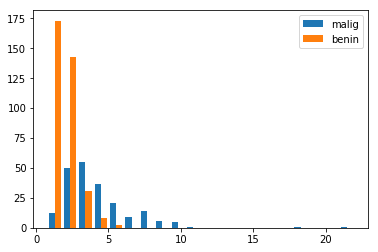

In [12]:
label = ['malig', 'benin']
_ = plt.hist([malig_smooth, benin_smooth], bins=20)
_ = plt.legend(label)

The `Benign-Smoothness` mean differs from the `Malignant-Smoothness` with Z-Score of 13+, meaning p-value far below 1e-3, meaning it is quite statistically significant that the two samples come from different distributions. 

We can also see the difference in the right tail between the two distributions graphically: `Malignant` has much fatter tail. 

These look like log-normal distirbutions, let's apply a log-transform to the `Smoothness` variable and see a close to normal distribution:

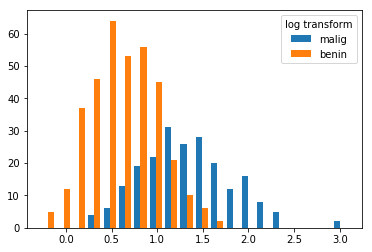

In [13]:
log_malig_smooth = np.log(malig_smooth)
log_benin_smooth = np.log(benin_smooth)

label = ['malig', 'benin']
_ = plt.hist([log_malig_smooth, log_benin_smooth], bins=20)
_ = plt.legend(label, title='log transform')

##### Build a bootstrap function

In [14]:
def bootstrap(data,pct_sampled=0.1, num_samples=None, seed=None):
    '''
        return: an index on `data` (list of int's) for a bootstrap sample
        input:
          data -        (pd.DataFrame)
          pct_sampled - (float or None) return pct
          num_samples - (int or None)   return len num_samples
          seed -        (int or None)   seed that int before rand operation
    '''
    
    assert pct_sampled is not None or num_samples is not None, \
           'must have a value for pct_sampled or num_samples '
    
    if seed is not None and isinstance(seed, int):
        np.random.seed(seed)
        
    n = len(data)
    
    ret_obs = ( int(pct_sampled * n) 
                if pct_sampled is not None else
                num_samples
              )
    
    return [np.random.randint(low=0, high=n-1) 
            for _ in range(ret_obs)
           ]
    

In [15]:
sample1 = bootstrap(data, pct_sampled=0.1, seed=0)

sample2 = bootstrap(data, pct_sampled=0.2)

sample3 = bootstrap(data, pct_sampled=None, num_samples=200)

print('indexes             |  sample size')
print( *[(str(e[:3]) + '...', len(e)) for e in [sample1, sample2, sample3]]
       ,sep='\n')

indexes             |  sample size
('[559, 192, 359]...', 56)
('[47, 131, 180]...', 113)
('[73, 297, 394]...', 200)


In [16]:
sample1_ind = pd.Series([e in sample1 for e in data.index.tolist()])
sample1_data = data[sample1_ind]
sample1_data.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.2396,0.2273,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750
28,852973,M,15.30,25.27,102.40,732.4,0.10820,0.1697,0.1683,0.08751,...,20.27,36.71,149.30,1269.0,0.1641,0.6110,0.6335,0.2024,0.4027,0.09876
42,855625,M,19.07,24.81,128.30,1104.0,0.09081,0.2190,0.2107,0.09961,...,24.09,33.17,177.40,1651.0,0.1247,0.7444,0.7242,0.2493,0.4670,0.10380
53,857392,M,18.22,18.70,120.30,1033.0,0.11480,0.1485,0.1772,0.10600,...,20.60,24.13,135.10,1321.0,0.1280,0.2297,0.2623,0.1325,0.3021,0.07987
57,857793,M,14.71,21.59,95.55,656.9,0.11370,0.1365,0.1293,0.08123,...,17.87,30.70,115.70,985.5,0.1368,0.4290,0.3587,0.1834,0.3698,0.10940


##### Exploratory Analysis

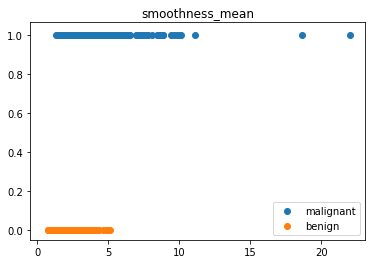

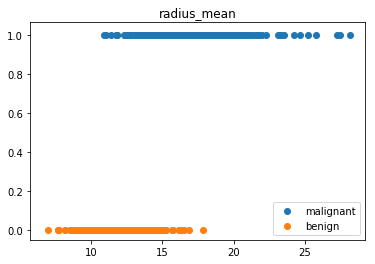

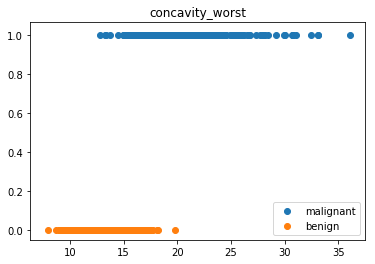

In [17]:
def plot_field(field_name):
    
    malig_x = data[(data['diagnosis'] == 'M')][field_name]
    benin_x = data[(data['diagnosis'] == 'B')][field_name]

    _ = plt.scatter(malig_x, [1 for _ in range(len(malig_x))])
    _ = plt.scatter(benin_x, [0 for _ in range(len(benin_x))])
    _= plt.legend(['malignant', 'benign'])
    _ = plt.title(field_name)
    plt.show()
    
plot_field('smoothness_mean')
plot_field('radius_mean')
plot_field('concavity_worst')

We can see there are large intervals at the min/max tails of `radius_mean` and `concavity_worst`, where these variables are perfect predictors of diagnosis: there are no malignant cases with radius < 10 and no benign cases with radius > 20. But a large portion of the data is distributed in the middle, e..g 12 to 17 for radius_mean, where radius can not predict diagnosis by itself. It looks like the naive view, "Very Big is Very Bad" is a subset of the dataset, for the rest we'll need multi-variable tools.

##### Prepare Dataset for Modelling

In [22]:
pct_test = 0.2
test_ind = int(pct_test * len(data))

data_train = data[test_ind:]
data_test  = data[:test_ind]

In [23]:
x_fields = [e for e in data.columns if e not in ('ID', 'diagnosis')]
y_fields = ['diagnosis']
y_fields = 'diagnosis'

train_x = data_train[x_fields]
train_y = data_train[y_fields]

test_x = data_test[x_fields]
test_y = data_test[y_fields]

In [24]:
train_x.shape, train_y.shape

((456, 30), (456,))

In [25]:
test_x.shape, test_y.shape

((113, 30), (113,))

##### Build Classifiers

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=500, max_depth=6)

In [28]:
_ = rf.fit(train_x, train_y)

In [29]:
rf.score(train_x, train_y,)

0.9978070175438597

In [30]:
rf.score(test_x, test_y,)

0.8938053097345132

##### Consider parameter `max_depth`  and it's effect on overfitting
higher max_depth for our trees gives us more predictive power, but also creates the possibility for overfitting. We'll do [1-dimensional] grid search on this paramter and compare the improvement in training performance vs the improvement in test perfromance.

In [31]:
train_scores, test_scores = [], []

for md in range(1,15):
    
    _rf = RandomForestClassifier(n_estimators=500, max_depth=md)
    _ = _rf.fit(train_x, train_y)
    
    train_scores.append(_rf.score(train_x, train_y,))
    test_scores.append(_rf.score(test_x, test_y,))

(0.9452, 0.7876)
(0.9715, 0.8761)
(0.9781, 0.885)
(0.9868, 0.8938)
(0.9912, 0.9027)
(0.9978, 0.9115)
(1.0, 0.9115)
(1.0, 0.9115)
(1.0, 0.9204)
(1.0, 0.9027)
(1.0, 0.9115)
(1.0, 0.9115)
(1.0, 0.9204)
(1.0, 0.9204)


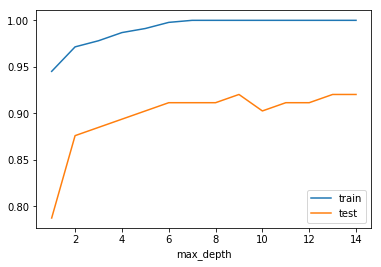

In [32]:
x = [e for e in range(1,15)]
_ = plt.plot(x, train_scores)
_ = plt.plot(x, test_scores)
_= plt.legend(['train', 'test'])
_= plt.xlabel('max_depth')

print( *[(round(a,4),round(b,4)) for a,b in 
          zip(train_scores, test_scores)], sep='\n')

A max_depth > 7 does not seem to improve perfromance on test sample, while it does steadily improve train towards the ludicrous 0-error perfromance, I'd cap that parameter there.

##### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lr = LogisticRegression(penalty='l2', solver='newton-cg')
_ = lr.fit(train_x, train_y)

In [35]:
lr.score(train_x, train_y)

0.9649122807017544

In [36]:
lr.score(test_x, test_y)

0.911504424778761

##### Analyze Feature Importance

In [37]:
rf_features = pd.Series(rf.feature_importances_, index=train_x.columns, )

In [38]:
rf_top_features = rf_features.sort_values(ascending=False)
rf_top_features[:6]

concave_points_worst       0.142025
concavity_worst            0.141479
concave_points_sd_error    0.132313
fractal_dimension_mean     0.099622
radius_worst               0.080235
perimeter_sd_error         0.071185
dtype: float64

In [39]:
lr_features = pd.Series(lr.coef_[0], index=train_x.columns, )

lr_top_features_pos = lr_features.sort_values(ascending=False, )
lr_top_features_neg = lr_features.sort_values(ascending=True, )

lr_top_features = lr_top_features_pos[:3]
lr_top_features.append(lr_top_features_neg[:3])

symmetry_worst                1.175744
symmetry_sd_error             0.602197
fractal_dimension_sd_error    0.589030
radius_mean                  -0.947834
area_worst                   -0.741932
concavity_worst              -0.638735
dtype: float64

Many of these features appear to be correlated ("multi-collinearity") and this will be difficult for logistic regression to deal with, even with using an L2-regularization. It will also mean that different basis function or even different solvers could find drastically different variable importance ("Rashomon conclusions") for roughly equal model importance.

Random Forest seem to identify multiple metrics on concavity as of the highest importantance, while logistic regression does not.

We see that `concavity_worst` is a variable shared across different Learners as in top6 impact. 

##### Technichal Interpretation

These models should be thought of as naive baselines for further modelling. We see a baseline of 94% accuracy on training set (which can be cranked to 100%) and 89-91% on the test set. Two steps to pursue before even bringing in more advanced modelling techniques: 1.) normalize the dataset, and perhaps apply some log transforms to some features to make them distributed more normally. 2.) build more cross validation samples to view how the model fits/tests under different dataset-splits.

##### Non-Technichal Interpretation

We used two techniques to identify the factors that predict malignant vs benign tumors using two dozen statistics calculated on images of the cells/tumor.

Each of these techniques has roughly 90% accurracy.

When exploring the factors individually, like radius, we see a sample at each *extreme* of the distribution are highlypredictive, while there is not a good predictive separation in the *middle* of the distribtuion. For example if all observations have a radius 1-20, and observation with radius 1-3 are very likely benign, and observation with radius 17-20 are very likely malignant. But for a radius of 8-12, we would need more information.

So, the real challenge is this situation is not separating the clearly malignant from the clearly benign, but trying to separate the two, when the situations is ambiguous on some factors.